target_native_gates = ['Hadamard','X','RY','RZ','CNOT','CZ']

In [5]:
import pennylane as qml
from qco_spec_table import show_circuit, my_loop, my_loop_unitary, summary_penny
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
[ds] = qml.data.load("ketgpt")

In [3]:
# example
seed = 5
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

In [7]:
df = pd.DataFrame(columns=['uni_1','uni_12'])
df['uni_1'] = summary_penny(my_loop(circuit))
df['uni_12'] = summary_penny(my_loop_unitary(circuit))
df.index = ['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']
df

,uni_1,uni_12
Gate count,161,142
Single-qubit gate count,50,46
Two-qubit gate count,111,96
Circuit depth,33,25


In [13]:
def comp_table_uni(circuit): 
    df = pd.DataFrame(columns=['uni_1','uni_12'])
    df['Original'] = summary_penny(circuit)
    df['uni_1'] = summary_penny(my_loop(circuit))
    df['uni_12'] = summary_penny(my_loop_unitary(circuit))
    df.index = ['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']
    return df

In [14]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        df = comp_table_uni(circuit)
        dfs.append(df)
    except:
        pass

In [15]:
len(dfs)

1000

In [16]:
dfs[0]

,uni_1,uni_12,Original
Gate count,31,31,141
Single-qubit gate count,12,12,116
Two-qubit gate count,19,19,25
Circuit depth,12,12,32


In [17]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,uni_1,uni_12
Gate count,0.220,0.220
Single-qubit gate count,0.103,0.103
Two-qubit gate count,0.760,0.760
Circuit depth,0.375,0.375


In [18]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

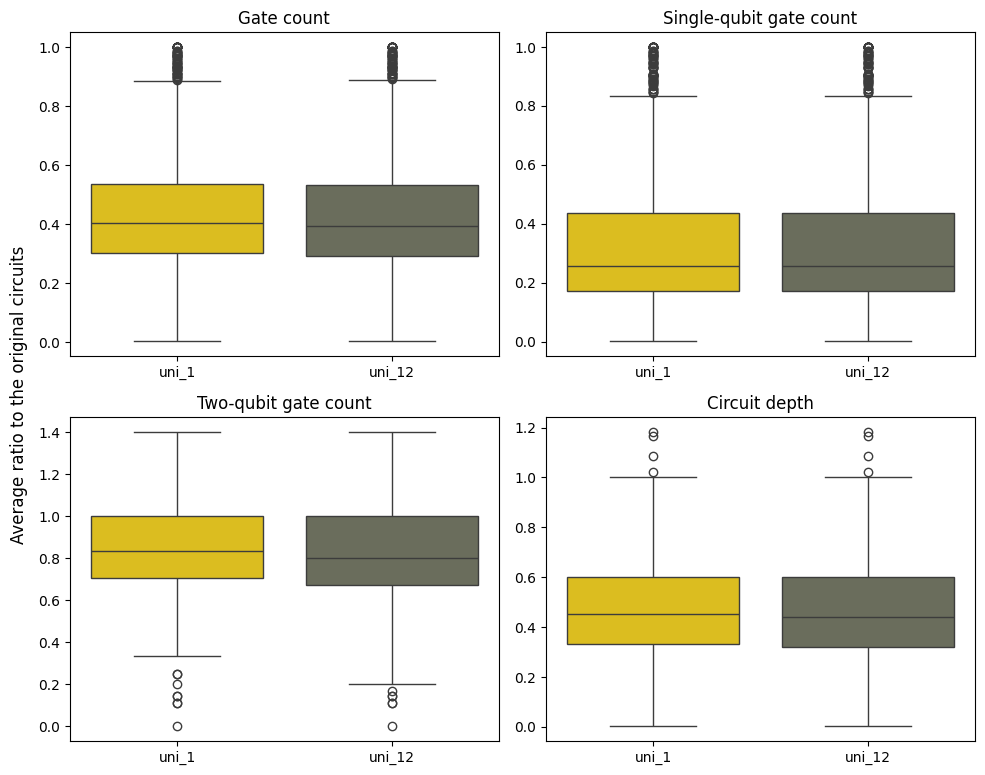

In [20]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8))
for i, metric in enumerate(['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'uni_1': "#FAD201", 'uni_12': "#6C7059"})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gate count')
    elif i==2:
        ax.set_title('Two-qubit gate count')
    elif i==3:
        ax.set_title('Circuit depth')
    ax.set_xlabel('')
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

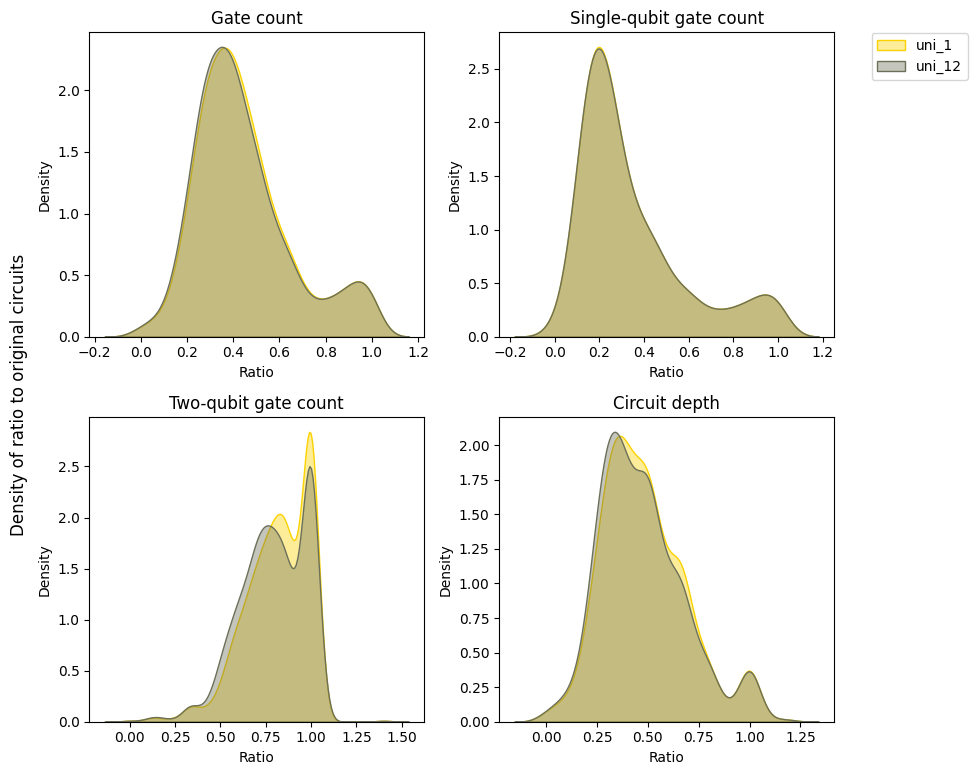

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

methods = {'uni_1': "#FAD201", 'uni_12': "#6C7059"}

for i, metric in enumerate(['Gate count', 'Single-qubit gate count', 'Two-qubit gate count', 'Circuit depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]

    # KDE plots per method
    for method, color in methods.items():
        sns.kdeplot(
            data=subset[subset['method'] == method],
            x='ratio',
            ax=ax,
            label=method,
            color=color,
            fill=True,
            alpha=0.4
        )

    # Titles
    ax.set_title(metric)
    ax.set_xlabel('Ratio')
    ax.set_ylabel('Density')

# --- Draw legend only once, next to the second subplot ---
# Pick the second subplot (index 1)
handles, labels = axes.flatten()[1].get_legend_handles_labels()
axes.flatten()[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.42, 1.02))

fig.supylabel('Density of ratio to original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [23]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,uni_1,Circuit depth,0.482553,0.208010,51.744700
1,uni_1,Gate count,0.448050,0.210813,55.195000
2,uni_1,Single-qubit gate count,0.343060,0.241446,65.694000
3,uni_1,Two-qubit gate count,0.814212,0.174906,18.578824
4,uni_12,Circuit depth,0.472463,0.210229,52.753700
5,uni_12,Gate count,0.442181,0.212638,55.781900
6,uni_12,Single-qubit gate count,0.342837,0.241630,65.716300
7,uni_12,Two-qubit gate count,0.791429,0.181922,20.857112


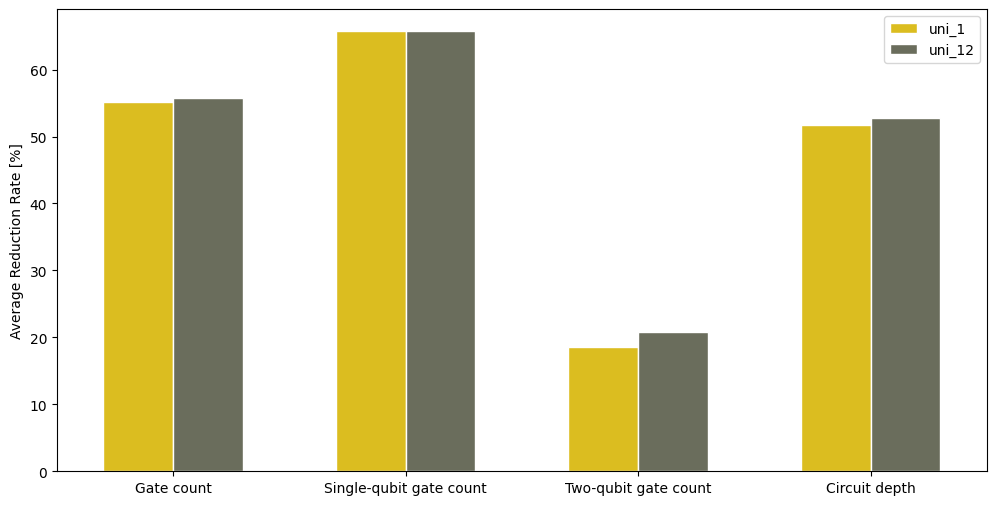

In [25]:
# Drop rows where metric == 'gate types'
df_filtered = mean_df[mean_df["metric"] != "gate types"]

palette = {'uni_1': "#FAD201", 'uni_12': "#6C7059"}

metric_order = ['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_filtered,
    x="metric",
    y="mean_percent",
    hue="method",
    order=metric_order, 
    palette=palette,
    errorbar="sd",
    width=0.6,
    edgecolor='white'
)

plt.ylabel("Average Reduction Rate [%]")
plt.legend()
plt.xlabel('')
plt.show()